<a href="https://colab.research.google.com/github/imrealhelper/Aerospace_-experiment_Control/blob/main/ESKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Error State Kalman Filter (ESKF)

## 1. 시스템 상태 정의 (State Definition)

ESKF는 시스템의 상태를 **Nominal State(명목 상태)**와 **Error State(오차 상태)**로 분리하여 다룬다. Nominal State는 비선형 기구학 방정식을 따라 적분되며, Error State는 선형화된 오차 동역학을 따른다.

### 1.1 Nominal State ($x$)
시스템의 Nominal State는 위치($p$), 속도($v$), 자세 쿼터니언($q$), 가속도계 바이어스($b_a$), 자이로 바이어스($b_g$)로 구성된다.

$$
x = [p^T, v^T, q^T, b_a^T, b_g^T]^T
$$

### 1.2 Error State ($\delta x$)
Error State는 Nominal State와 참값(True State) 간의 차이를 나타내며, 쿼터니언의 오차는 3차원 회전 벡터($\delta \theta$)로 표현되어 총 15차원의 상태 벡터를 갖는다.

$$
\delta x = [\delta p^T, \delta v^T, \delta \theta^T, \delta b_a^T, \delta b_g^T]^T \in \mathbb{R}^{15}
$$

코드 내 `ESKF_Tunable` 클래스의 `__init__` 메서드에서 해당 변수들이 초기화되며, 오차 공분산 행렬 $P$는 $15 \times 15$ 행렬로 정의된다.

## 2. 예측 단계 (Time Propagation)

예측 단계에서는 IMU의 가속도($a_m$)와 角속도($\omega_m$) 데이터를 이용하여 Nominal State를 적분하고, 오차 공분산 행렬 $P$를 전파한다. 이는 `predict` 메서드에 구현되어 있다.

### 2.1 Nominal State 적분
위치와 속도는 등가속도 운동 방정식을, 자세는 쿼터니언 미분 방정식을 통해 갱신된다.

$$
p_{k+1} = p_k + v_k \Delta t + \frac{1}{2} (R(q_k)(a_m - b_{a,k}) + g) \Delta t^2
$$
$$
v_{k+1} = v_k + (R(q_k)(a_m - b_{a,k}) + g) \Delta t
$$
$$
q_{k+1} = q_k \otimes q \{ (\omega_m - b_{g,k}) \Delta t \}
$$

코드 구현:
```python
# 가속도 및 자이로 보정 (Bias 제거)
acc_corrected = acc_m - self.b_a
gyro_corrected = gyro_m - self.b_g
acc_nav = rot_mat @ acc_corrected + self.g

# 위치 및 속도 적분
self.p = self.p + self.v * dt + 0.5 * acc_nav * dt**2
self.v = self.v + acc_nav * dt

# 자세 적분 (Rodrigues' rotation formula approximation)
dq = R.from_rotvec(axis * angle)
self.q = (R.from_quat(self.q) * dq).as_quat()
````

### 2.2 Error Covariance 전파

오차 상태의 동역학은 선형화된 시스템 행렬 $F_x$를 통해 전파된다.

$$
\delta x_{k+1} = F_x \delta x_k + w_k
$$

$$
P_{k+1} = F_x P_k F_x^T + Q
$$

여기서 $F_x$는 다음과 같은 구조를 갖는다 (간략화된 형태):

$$
F_x = \begin{bmatrix}
I & I \Delta t & 0 & 0 & 0 \\
0 & I & -R(q_k)[a_m - b_a]_{\times} \Delta t & -R(q_k) \Delta t & 0 \\
0 & 0 & I & 0 & -R(q_k) \Delta t \\
0 & 0 & 0 & I & 0 \\
0 & 0 & 0 & 0 & I
\end{bmatrix}$$

코드 구현:

```python
Fx = np.eye(15)
Fx[0:3, 3:6] = np.eye(3) * dt
Fx[3:6, 6:9] = - (rot_mat @ self._skew(acc_corrected)) * dt
Fx[3:6, 9:12] = - rot_mat * dt
Fx[6:9, 12:15] = - rot_mat * dt

# Process Noise Covariance Q
Q[3:6, 3:6] = np.eye(3) * self.sigma_acc**2 * dt**2
...
self.P = Fx @ self.P @ Fx.T + Q
```

## 3\. 측정 업데이트 단계 (Measurement Update)

GPS로부터 위치 및 속도 데이터가 수신되면 `update_gps` 메서드를 통해 상태를 보정한다.

### 3.1 칼만 이득 계산 및 오차 추정

측정 잔차 $y$와 측정 야코비안 $H$를 이용하여 오차 상태 $\delta x$를 추정한다.

$$
K = P H^T (H P H^T + R)^{-1}
$$

$$
\delta x = K (z - h(x_{nom}))
$$

여기서 $z$는 GPS 측정값, $h(x_{nom})$은 Nominal State로부터 예측된 측정값이다.

코드 구현:

```python
residual = z - h
S = H @ self.P @ H.T + R_cov
K = self.P @ H.T @ np.linalg.inv(S)
dx = K @ residual  # dx가 Error State vector
```

### 3.2 Error Injection (상태 보정)

추정된 오차 상태 $\delta x$를 Nominal State에 주입하여 참값을 갱신하고, Error State는 0으로 리셋한다 (ESKF의 핵심 과정).

$$
p \leftarrow p + \delta p, \quad v \leftarrow v + \delta v
$$

$$
q \leftarrow q \otimes \text{exp}(\delta \theta), \quad b \leftarrow b + \delta b
$$

코드 구현:

```python
self.p += dx[0:3]
self.v += dx[3:6]
d_theta = dx[6:9]
dq = R.from_rotvec(d_theta)
self.q = (R.from_quat(self.q) * dq).as_quat() # 쿼터니언 보정
self.b_a += dx[9:12]
self.b_g += dx[12:15]
```


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import optuna # pip install optuna

# -----------------------------------------------------------------------------
# 1. Classes & Utils (Optimized for repeated calls)
# -----------------------------------------------------------------------------
class GeoUtils:
    CONSTANTS_RADIUS_OF_EARTH = 6371000.0
    @staticmethod
    def global_to_local(lat, lon, lat_0, lon_0):
        lat_rad, lon_rad = np.deg2rad(lat), np.deg2rad(lon)
        lat_0_rad, lon_0_rad = np.deg2rad(lat_0), np.deg2rad(lon_0)
        d_lat = lat_rad - lat_0_rad
        d_lon = lon_rad - lon_0_rad
        north = d_lat * GeoUtils.CONSTANTS_RADIUS_OF_EARTH
        east = d_lon * GeoUtils.CONSTANTS_RADIUS_OF_EARTH * np.cos(lat_0_rad)
        return north, east
class ESKF_Tunable:
    def __init__(self, init_pos, init_vel, init_quat, init_ba, init_bg, params):
        self.p = init_pos.copy()
        self.v = init_vel.copy()
        self.q = init_quat.copy() # [x, y, z, w]
        self.b_a = init_ba.copy()
        self.b_g = init_bg.copy()

        # Tunable Parameters
        self.sigma_acc = params['sigma_acc']
        self.sigma_gyro = params['sigma_gyro']
        self.sigma_acc_bias = params['sigma_acc_bias']
        self.sigma_gyro_bias = params['sigma_gyro_bias']

        self.P = np.eye(15)
        self.P[0:3, 0:3] *= 1.0
        self.P[3:6, 3:6] *= 0.1
        self.P[6:9, 6:9] *= 0.01
        self.P[9:15, 9:15] *= 1e-4

        self.g = np.array([0, 0, 9.80665]) # NED Frame Gravity

    def predict(self, acc_m, gyro_m, dt):
        if dt <= 0: return

        # 1. Nominal State Update
        rm = R.from_quat(self.q)
        rot_mat = rm.as_matrix()

        acc_corrected = acc_m - self.b_a
        gyro_corrected = gyro_m - self.b_g

        # a_nav = R * (a_b) + g
        acc_nav = rot_mat @ acc_corrected + self.g

        # Position & Velocity Update (Euler Integration)
        self.p = self.p + self.v * dt + 0.5 * acc_nav * dt**2
        self.v = self.v + acc_nav * dt

        # Quaternion Update
        angle = np.linalg.norm(gyro_corrected * dt)
        if angle > 1e-12:
            axis = (gyro_corrected * dt) / angle
            dq = R.from_rotvec(axis * angle)
        else:
            dq = R.from_quat([0, 0, 0, 1])

        # q_new = q_old * dq (Body frame rotation)
        self.q = (rm * dq).as_quat()
        self.q /= np.linalg.norm(self.q)

        # 2. Error State Jacobian (Fx) - Standard Sola Method (Error in Body)
        Fx = np.eye(15)

        # Position derivatives
        Fx[0:3, 3:6] = np.eye(3) * dt

        # Velocity derivatives
        # dv/dtheta = - R * [acc]x * dt
        Fx[3:6, 6:9] = - (rot_mat @ self._skew(acc_corrected)) * dt
        # dv/dba = - R * dt
        Fx[3:6, 9:12] = - rot_mat * dt

        # Attitude derivatives (Body Frame Error)
        # dtheta/dtheta = R{w*dt}.T (Transpose of rotation increment)
        # Small angle approximation: I - [w*dt]x
        delta_rot_mat = dq.as_matrix().T
        Fx[6:9, 6:9] = delta_rot_mat

        # dtheta/dbg = - I * dt (Critical Fix!)
        Fx[6:9, 12:15] = - np.eye(3) * dt

        # 3. Process Noise (Q)
        # Note: Discrete approximations can vary, but this is acceptable
        Q = np.zeros((15, 15))
        Q[3:6, 3:6] = np.eye(3) * self.sigma_acc**2 * dt**2
        Q[6:9, 6:9] = np.eye(3) * self.sigma_gyro**2 * dt**2
        Q[9:12, 9:12] = np.eye(3) * self.sigma_acc_bias**2 * dt
        Q[12:15, 12:15] = np.eye(3) * self.sigma_gyro_bias**2 * dt

        self.P = Fx @ self.P @ Fx.T + Q
        self.P = (self.P + self.P.T) / 2

    def update_gps(self, pos_gps, vel_gps, r_pos, r_vel):
        # Measurement matrix H is Identity for Position and Velocity
        # Standard ESKF maps: z ~ H * x_error
        # Residual = z_meas - z_pred

        z = np.concatenate([pos_gps, vel_gps])
        h = np.concatenate([self.p, self.v])
        residual = z - h

        H = np.zeros((6, 15))
        H[0:3, 0:3] = np.eye(3)
        H[3:6, 3:6] = np.eye(3)

        R_cov = np.zeros((6, 6))
        R_cov[0:3, 0:3] = np.eye(3) * r_pos
        R_cov[3:6, 3:6] = np.eye(3) * r_vel

        # Kalman Gain
        S = H @ self.P @ H.T + R_cov
        K = self.P @ H.T @ np.linalg.inv(S)

        dx = K @ residual

        # State Injection
        self.p += dx[0:3]
        self.v += dx[3:6]

        # Attitude Injection (Body Frame)
        d_theta = dx[6:9]
        dq = R.from_rotvec(d_theta)
        # Correct: q_new = q_old * dq_correction
        self.q = (R.from_quat(self.q) * dq).as_quat()
        self.q /= np.linalg.norm(self.q)

        self.b_a += dx[9:12]
        self.b_g += dx[12:15]

        # Covariance Update (Joseph form for stability)
        I = np.eye(15)
        temp = I - K @ H
        self.P = temp @ self.P @ temp.T + K @ R_cov @ K.T
        self.P = (self.P + self.P.T) / 2

    def _skew(self, v):
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
# -----------------------------------------------------------------------------
# 2. Data Loading (Load once globally)
# -----------------------------------------------------------------------------
print("[INFO] Loading Datasets...")
df_imu = pd.read_csv('log_2_2024-12-3-07-52-28_sensor_combined_0.csv')
df_gps = pd.read_csv('log_2_2024-12-3-07-52-28_sensor_gps_0.csv')
df_att = pd.read_csv('log_2_2024-12-3-07-52-28_vehicle_attitude_0.csv')
df_truth = pd.read_csv('log_2_2024-12-3-07-52-28_vehicle_local_position_0.csv')
# Pre-calculate Global Refs and Initial States
t0 = df_imu['timestamp'].iloc[0]

# Reference (Try to match Truth Frame)
if 'ref_lat' in df_truth.columns and not np.isnan(df_truth['ref_lat'].iloc[0]):
    ref_lat, ref_lon, ref_alt = df_truth['ref_lat'].iloc[0], df_truth['ref_lon'].iloc[0], df_truth['ref_alt'].iloc[0]
else:
    ref_lat, ref_lon, ref_alt = df_gps['lat'].iloc[0]*1e-7, df_gps['lon'].iloc[0]*1e-7, df_gps['alt'].iloc[0]*1e-3

# Initial State
init_vel = np.array([df_truth['vx'].iloc[0], df_truth['vy'].iloc[0], df_truth['vz'].iloc[0]])
q0_row = df_att.iloc[0]
init_quat = np.array([q0_row['q[1]'], q0_row['q[2]'], q0_row['q[3]'], q0_row['q[0]']])
init_pos = np.array([0.0, 0.0, 0.0]) # Start relative to origin
init_ba = np.zeros(3)
init_bg = np.zeros(3)

# Pre-process GPS data for faster lookup
gps_times = df_gps['timestamp'].values
gps_lats = df_gps['lat'].values * 1e-7
gps_lons = df_gps['lon'].values * 1e-7
gps_alts = df_gps['alt'].values * 1e-3
gps_vn = df_gps['vel_n_m_s'].values
gps_ve = df_gps['vel_e_m_s'].values
gps_vd = df_gps['vel_d_m_s'].values
gps_fix = df_gps['fix_type'].values
gps_eph = df_gps['eph'].values
gps_s_var = df_gps['s_variance_m_s'].values

# Pre-process Truth for RMSE (Align to origin 0,0,0 if needed, but assuming NED is consistent)
truth_t = (df_truth['timestamp'].values - t0) * 1e-6
truth_x = df_truth['x'].values
truth_y = df_truth['y'].values
truth_z = df_truth['z'].values

# -----------------------------------------------------------------------------
# 3. Optimization Logic
# -----------------------------------------------------------------------------
def run_eskf_simulation(params):
    eskf = ESKF_Tunable(init_pos, init_vel, init_quat, init_ba, init_bg, params)

    idx_gps = 0
    len_gps = len(gps_times)

    est_t = []
    est_pos = []

    # Main Loop (Optimized using numpy arrays where possible)
    imu_times = df_imu['timestamp'].values
    acc_cols = df_imu[['accelerometer_m_s2[0]', 'accelerometer_m_s2[1]', 'accelerometer_m_s2[2]']].values
    gyro_cols = df_imu[['gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]']].values

    # Limit simulation length for speed if needed (e.g., first 30 seconds)
    # But for accuracy, we run full log.

    for i in range(1, len(imu_times)):
        curr_time = imu_times[i]
        dt = (curr_time - imu_times[i-1]) * 1e-6

        # Predict
        eskf.predict(acc_cols[i-1], gyro_cols[i-1], dt)

        # Update
        while idx_gps < len_gps and gps_times[idx_gps] <= curr_time:
            if gps_fix[idx_gps] >= 3:
                n, e = GeoUtils.global_to_local(gps_lats[idx_gps], gps_lons[idx_gps], ref_lat, ref_lon)
                d = -(gps_alts[idx_gps] - ref_alt)

                pos_gps = np.array([n, e, d])
                vel_gps = np.array([gps_vn[idx_gps], gps_ve[idx_gps], gps_vd[idx_gps]])

                r_pos = max(gps_eph[idx_gps]**2, 0.5**2)
                r_vel = max(gps_s_var[idx_gps]**2, 0.1**2)

                eskf.update_gps(pos_gps, vel_gps, r_pos, r_vel)
            idx_gps += 1

        if i % 10 == 0: # Downsample recording to save memory/time
            est_t.append((curr_time - t0) * 1e-6)
            est_pos.append(eskf.p.copy())

    return np.array(est_t), np.array(est_pos)

[INFO] Loading Datasets...


In [14]:
def run_eskf_simulation_full(params):
    eskf = ESKF_Tunable(init_pos, init_vel, init_quat, init_ba, init_bg, params)

    idx_gps = 0
    len_gps = len(gps_times)

    est_t = []
    est_pos = []
    est_vel = []
    est_att = [] # Euler angles (Roll, Pitch, Yaw)

    imu_times = df_imu['timestamp'].values
    acc_cols = df_imu[['accelerometer_m_s2[0]', 'accelerometer_m_s2[1]', 'accelerometer_m_s2[2]']].values
    gyro_cols = df_imu[['gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]']].values

    for i in range(1, len(imu_times)):
        curr_time = imu_times[i]
        dt = (curr_time - imu_times[i-1]) * 1e-6

        # Predict
        eskf.predict(acc_cols[i-1], gyro_cols[i-1], dt)

        # Update (GPS)
        while idx_gps < len_gps and gps_times[idx_gps] <= curr_time:
            if gps_fix[idx_gps] >= 3:
                n, e = GeoUtils.global_to_local(gps_lats[idx_gps], gps_lons[idx_gps], ref_lat, ref_lon)
                d = -(gps_alts[idx_gps] - ref_alt)
                pos_gps = np.array([n, e, d])
                vel_gps = np.array([gps_vn[idx_gps], gps_ve[idx_gps], gps_vd[idx_gps]])
                r_pos = max(gps_eph[idx_gps]**2, 0.5**2)
                r_vel = max(gps_s_var[idx_gps]**2, 0.1**2)
                eskf.update_gps(pos_gps, vel_gps, r_pos, r_vel)
            idx_gps += 1

        # Logging (Downsampling 10Hz approx)
        if i % 10 == 0:
            est_t.append((curr_time - t0) * 1e-6)
            est_pos.append(eskf.p.copy())
            est_vel.append(eskf.v.copy())

            # Quat -> Euler (Z-Y-X sequence -> Yaw, Pitch, Roll)
            # Scipy returns [x, y, z] for intrinsic rotations
            r = R.from_quat(eskf.q)
            euler = r.as_euler('zyx', degrees=True) # [Yaw, Pitch, Roll]
            est_att.append([euler[2], euler[1], euler[0]]) # Save as [Roll, Pitch, Yaw]

    return np.array(est_t), np.array(est_pos), np.array(est_vel), np.array(est_att)

In [15]:
best_params = {'sigma_acc': 1.7244442656566408, 'sigma_gyro': 0.4492876654737183, 'sigma_acc_bias': 4.173908616710218e-05, 'sigma_gyro_bias': 1.7409331482466583e-05}

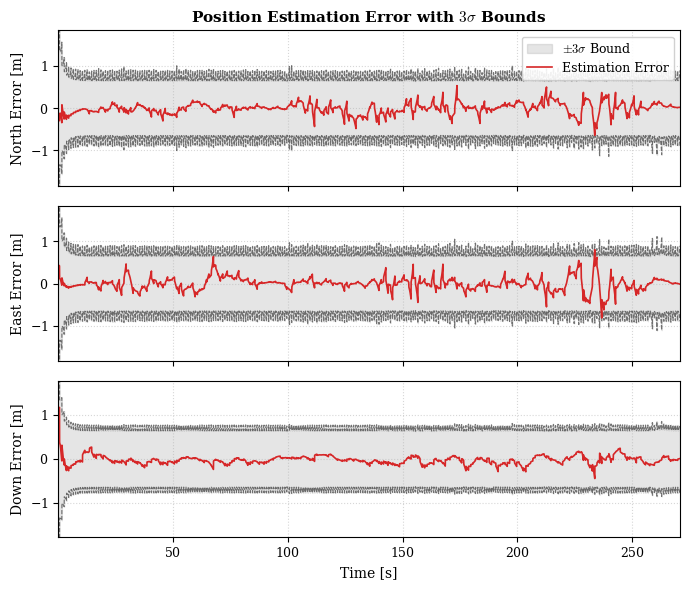

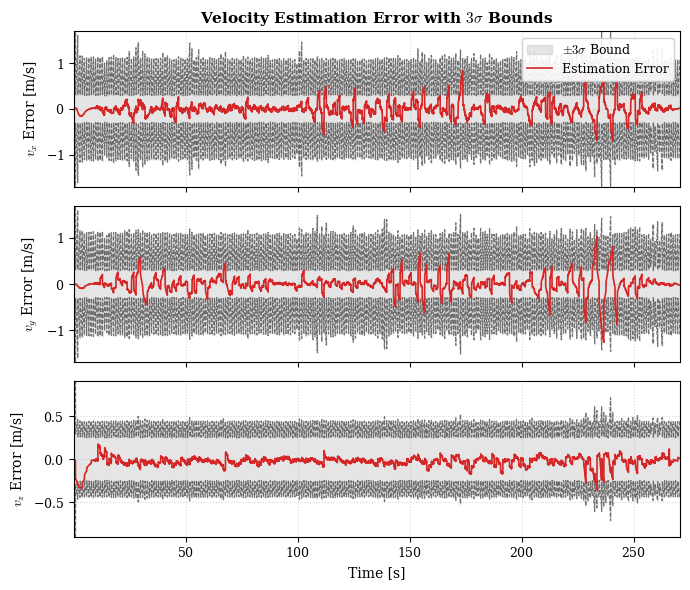

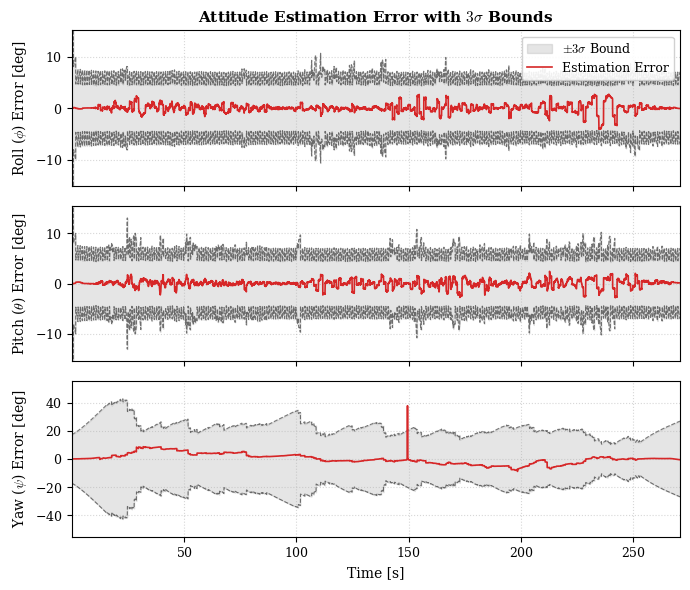

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams


def set_inha_style():
    # Font settings (Times New Roman implies formal academic standard)
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
    rcParams['font.size'] = 10
    rcParams['axes.labelsize'] = 10
    rcParams['axes.titlesize'] = 11
    rcParams['xtick.labelsize'] = 9
    rcParams['ytick.labelsize'] = 9
    rcParams['legend.fontsize'] = 9

    # Use mathtext for LaTeX-like rendering without requiring full LaTeX install
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.formatter.use_mathtext'] = True

    # Line and layout
    rcParams['lines.linewidth'] = 1.2
    rcParams['axes.grid'] = True
    rcParams['grid.alpha'] = 0.4
    rcParams['grid.linestyle'] = '--'
    rcParams['figure.autolayout'] = True
    rcParams['figure.figsize'] = (7, 8) # Width 7 inches is standard for full page width

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib import rcParams
set_inha_style()
# -----------------------------------------------------------------------------
# 1. 시뮬레이션 함수 재정의 (5개 값 반환하도록 수정됨)
# -----------------------------------------------------------------------------
def run_eskf_simulation(params):
    # ESKF 초기화
    eskf = ESKF_Tunable(init_pos, init_vel, init_quat, init_ba, init_bg, params)

    idx_gps = 0
    len_gps = len(gps_times)

    # 결과 저장용 리스트
    est_t = []
    est_pos = []
    est_vel = []
    est_att = []
    est_std = [] # 표준편차 (3-sigma bound용)

    imu_times = df_imu['timestamp'].values
    acc_cols = df_imu[['accelerometer_m_s2[0]', 'accelerometer_m_s2[1]', 'accelerometer_m_s2[2]']].values
    gyro_cols = df_imu[['gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]']].values

    for i in range(1, len(imu_times)):
        curr_time = imu_times[i]
        dt = (curr_time - imu_times[i-1]) * 1e-6

        # 1. Prediction
        eskf.predict(acc_cols[i-1], gyro_cols[i-1], dt)

        # 2. Update (GPS)
        while idx_gps < len_gps and gps_times[idx_gps] <= curr_time:
            if gps_fix[idx_gps] >= 3:
                n, e = GeoUtils.global_to_local(gps_lats[idx_gps], gps_lons[idx_gps], ref_lat, ref_lon)
                d = -(gps_alts[idx_gps] - ref_alt)

                pos_gps = np.array([n, e, d])
                vel_gps = np.array([gps_vn[idx_gps], gps_ve[idx_gps], gps_vd[idx_gps]])

                r_pos = max(gps_eph[idx_gps]**2, 0.5**2)
                r_vel = max(gps_s_var[idx_gps]**2, 0.1**2)

                eskf.update_gps(pos_gps, vel_gps, r_pos, r_vel)
            idx_gps += 1

        # 3. Logging (약 10Hz로 다운샘플링하여 저장)
        if i % 10 == 0:
            est_t.append((curr_time - t0) * 1e-6)
            est_pos.append(eskf.p.copy())
            est_vel.append(eskf.v.copy())

            # Quat -> Euler (Yaw, Pitch, Roll) -> Save as (Roll, Pitch, Yaw)
            r_curr = R.from_quat(eskf.q)
            euler = r_curr.as_euler('zyx', degrees=True)
            est_att.append([euler[2], euler[1], euler[0]])

            # Covariance (Extract diagonal, convert to std dev)
            std_dev = np.sqrt(np.diag(eskf.P))
            est_std.append(std_dev[:9]) # Save Pos(3), Vel(3), Att(3) std only

    # 5개의 값을 반환합니다.
    return np.array(est_t), np.array(est_pos), np.array(est_vel), np.array(est_att), np.array(est_std)

# -----------------------------------------------------------------------------
# 2. 데이터 준비 및 실행
# -----------------------------------------------------------------------------
# 함수 실행 (이제 5개의 값을 반환하므로 에러가 나지 않습니다)
t_est, p_est, v_est, att_est, std_est = run_eskf_simulation(best_params)

# Truth Data 로드 및 전처리
truth_pos_t = (df_truth['timestamp'].values - t0) * 1e-6
truth_pos = df_truth[['x', 'y', 'z']].values
truth_vel = df_truth[['vx', 'vy', 'vz']].values

truth_att_t = (df_att['timestamp'].values - t0) * 1e-6
truth_q = df_att[['q[1]', 'q[2]', 'q[3]', 'q[0]']].values
r_truth = R.from_quat(truth_q)
truth_euler = r_truth.as_euler('zyx', degrees=True)
truth_att = np.stack([truth_euler[:, 2], truth_euler[:, 1], truth_euler[:, 0]], axis=1) # [Roll, Pitch, Yaw]

# -----------------------------------------------------------------------------
# 3. 오차 계산 (Interpolation)
# -----------------------------------------------------------------------------
def get_interp_error(t_est, est_data, t_truth, truth_data):
    error = np.zeros_like(est_data)
    for i in range(3):
        truth_interp = np.interp(t_est, t_truth, truth_data[:, i])
        error[:, i] = est_data[:, i] - truth_interp
    return error

error_pos = get_interp_error(t_est, p_est, truth_pos_t, truth_pos)
error_vel = get_interp_error(t_est, v_est, truth_pos_t, truth_vel)
error_att = get_interp_error(t_est, att_est, truth_att_t, truth_att)
error_att[:, 2] = (error_att[:, 2] + 180) % 360 - 180 # Yaw Wrapping

# -----------------------------------------------------------------------------
# 4. AIAA 스타일 플롯 함수 (SyntaxWarning 수정됨)
# -----------------------------------------------------------------------------
def set_aiaa_style():
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.grid'] = True
    rcParams['grid.alpha'] = 0.5
    rcParams['grid.linestyle'] = ':'
    rcParams['lines.linewidth'] = 1.0
    rcParams['font.size'] = 10

def plot_error_analysis(t, error, sigma, labels, title, unit):
    set_aiaa_style()
    fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

    for i in range(3):
        # 3-Sigma Bounds
        ax[i].fill_between(t, 3*sigma[:, i], -3*sigma[:, i], color='gray', alpha=0.2, label=r'$\pm 3\sigma$ Bound')
        ax[i].plot(t, 3*sigma[:, i], 'k--', linewidth=0.8, alpha=0.5)
        ax[i].plot(t, -3*sigma[:, i], 'k--', linewidth=0.8, alpha=0.5)

        # Error
        ax[i].plot(t, error[:, i], color='#D62728', linewidth=1.2, label='Estimation Error')

        ax[i].set_ylabel(f'{labels[i]} Error [{unit}]')

        # Y-lim 자동 조절 (너무 튀는 값 제외)
        bound = np.mean(3*sigma[:, i]) * 2.5
        ax[i].set_ylim([-bound, bound])

        if i == 0:
            ax[i].legend(loc='upper right', frameon=True, framealpha=0.9)
            ax[i].set_title(title, fontweight='bold')

    ax[2].set_xlabel('Time [s]')
    ax[2].set_xlim([t[0], t[-1]])
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 5. 그래프 출력
# -----------------------------------------------------------------------------

# (1) Position Error Analysis (Raw string r'' 사용으로 경고 해결)
plot_error_analysis(t_est, error_pos, std_est[:, 0:3],
                    ['North', 'East', 'Down'],
                    r'Position Estimation Error with $3\sigma$ Bounds', 'm')

# (2) Velocity Error Analysis
plot_error_analysis(t_est, error_vel, std_est[:, 3:6],
                    [r'$v_x$', r'$v_y$', r'$v_z$'],
                    r'Velocity Estimation Error with $3\sigma$ Bounds', 'm/s')

# (3) Attitude Error Analysis
plot_error_analysis(t_est, error_att, np.rad2deg(std_est[:, 6:9]),
                    [r'Roll ($\phi$)', r'Pitch ($\theta$)', r'Yaw ($\psi$)'],
                    r'Attitude Estimation Error with $3\sigma$ Bounds', 'deg')

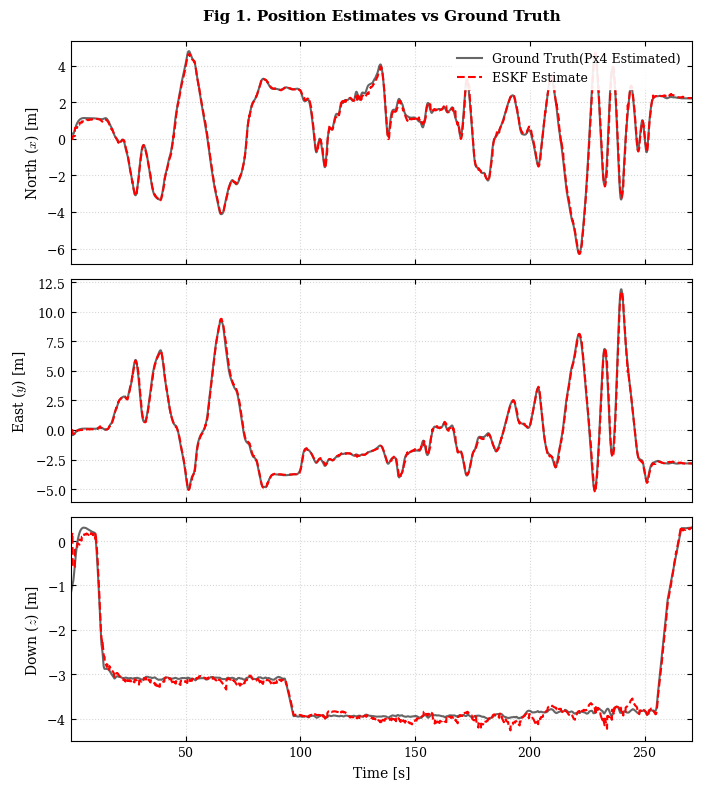

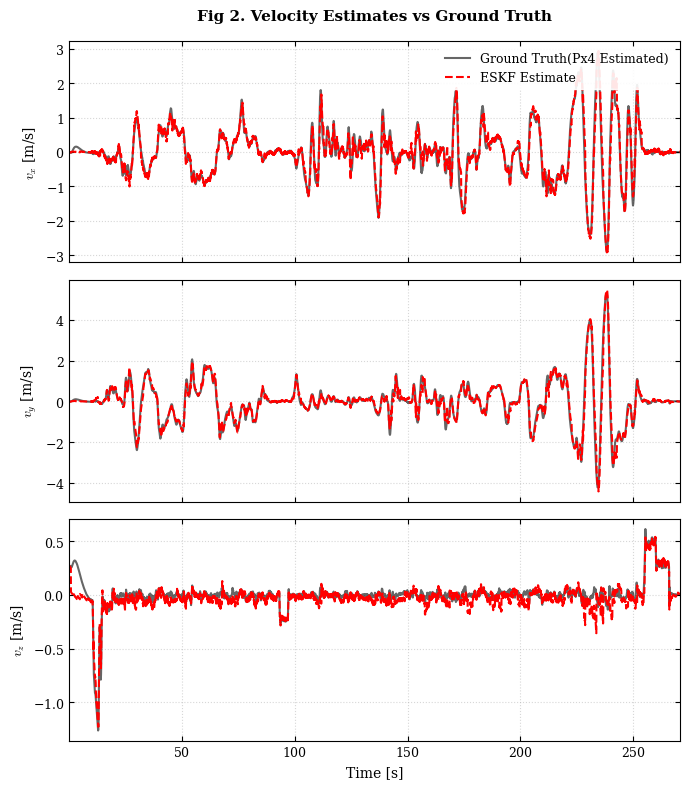

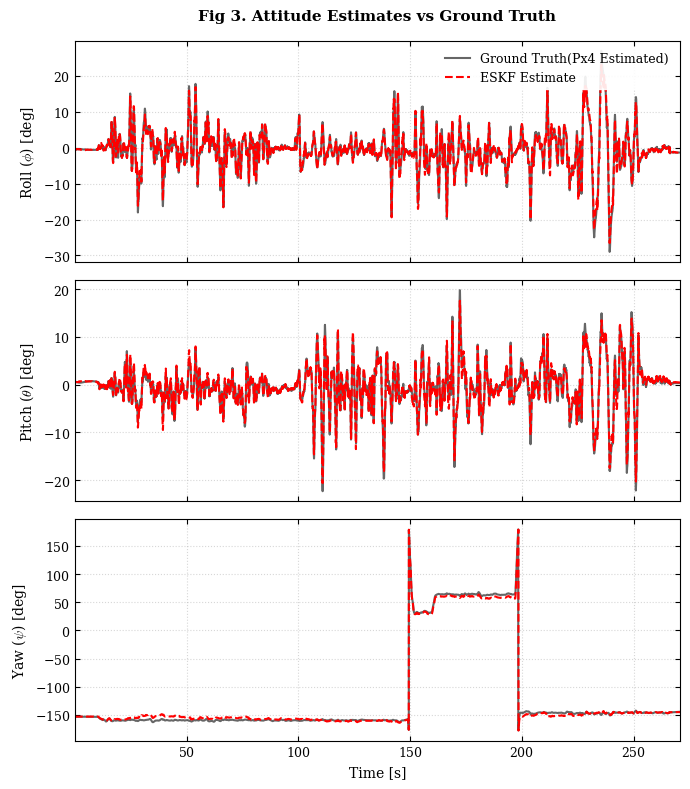

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

def set_inha_style():
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    rcParams['mathtext.fontset'] = 'cm' # LaTeX style math
    rcParams['axes.grid'] = True
    rcParams['grid.alpha'] = 0.5
    rcParams['grid.linestyle'] = ':'
    rcParams['lines.linewidth'] = 1.2
    rcParams['font.size'] = 10
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'] = plt.cycler(color=['k', 'r', 'b', 'g']) # Default colors

set_inha_style()

def plot_state_comparison(t_est, est_data, t_truth, truth_data, labels, title, unit):
    set_aiaa_style()

    # Create 3x1 subplots
    fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)

    for i in range(3):
        # 1. Ground Truth (Black Solid Line, slightly transparent)
        # alpha=0.6으로 설정하여 뒤에 배경처럼 깔리게 함
        ax[i].plot(t_truth, truth_data[:, i], 'k-', linewidth=1.5, alpha=0.6, label='Ground Truth(Px4 Estimated)')

        # 2. ESKF Estimate (Red Dashed Line)
        # 추정값은 빨간색 점선으로 강조
        ax[i].plot(t_est, est_data[:, i], 'r--', linewidth=1.5, label='ESKF Estimate')

        # Labels & Styling
        ax[i].set_ylabel(f'{labels[i]} [{unit}]')
        ax[i].tick_params(direction='in', top=True, right=True)

        # Legend (맨 위 그래프에만 표시)
        if i == 0:
            ax[i].legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='white')
            ax[i].set_title(title, fontweight='bold', pad=15)

    # X-axis Label (Time)
    ax[2].set_xlabel('Time [s]')

    # Set X limits based on estimation time
    ax[2].set_xlim([t_est[0], t_est[-1]])

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 3. Generate Plots (Position, Velocity, Attitude)
# -----------------------------------------------------------------------------

# (1) Position Comparison
plot_state_comparison(
    t_est, p_est,
    truth_pos_t, truth_pos,
    ['North ($x$)', 'East ($y$)', 'Down ($z$)'],
    'Fig 1. Position Estimates vs Ground Truth',
    'm'
)

# (2) Velocity Comparison
plot_state_comparison(
    t_est, v_est,
    truth_pos_t, truth_vel,
    [r'$v_x$', r'$v_y$', r'$v_z$'],
    'Fig 2. Velocity Estimates vs Ground Truth',
    'm/s'
)

# (3) Attitude Comparison (Euler Angles)
plot_state_comparison(
    t_est, att_est,
    truth_att_t, truth_att,
    [r'Roll ($\phi$)', r'Pitch ($\theta$)', r'Yaw ($\psi$)'],
    'Fig 3. Attitude Estimates vs Ground Truth',
    'deg'
)